In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
from pathlib import Path
from collections import Counter
import re

import nltk
from nltk import ngrams
from nltk.corpus import stopwords
import textstat
from lexicalrichness import LexicalRichness
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [105]:
local_dir = Path(os.getcwd())
kaggle_dir = Path('kaggle/input/')

In [64]:
notebook_dir = local_dir

### Load data

In [106]:
data_dir = notebook_dir / 'llm-detect-ai-generated-text'
external_data_dir = notebook_dir / 'external-data'

In [107]:
# Competition data
train_essays = pd.read_csv(data_dir / 'train_essays.csv')
train_essays['dataset'] = 'competition'
train_prompts = pd.read_csv(data_dir / 'train_prompts.csv')
test_essays = pd.read_csv(data_dir / 'test_essays.csv')

In [108]:
# AI generated data
train_essays_ai = pd.read_csv(data_dir / 'train_essays_ai.csv')
train_essays_ai['dataset'] = 'ai-generated'

In [109]:
training_data = train_essays.copy()
training_data = pd.concat([training_data, train_essays_ai[['id', 'prompt_id', 'text', 'generated', 'dataset', 'model']]], axis=0)
training_data.rename(columns={'model': 'source'}, inplace=True)
training_data['source'].fillna('competition', inplace=True)

### External Data

In [110]:
# H3 data
h3_data = pd.read_json(external_data_dir / 'H3' / 'H3.jsonl', lines=True)
h3_data = h3_data[['human_answers', 'chatgpt_answers', 'source']]
h3_data.rename(columns={'human_answers': 'human', 'chatgpt_answers': 'ai_generated'}, inplace=True)
h3_data['dataset'] = 'H3'

In [111]:
# M4 data
m4_files = os.listdir(external_data_dir / 'M4')
m4_data = []
for file in m4_files:
    if file.startswith('arxiv'):
        file_data = pd.read_json(external_data_dir / 'M4' / file, lines=True)
        file_data['file'] = file
        file_data['source'] = 'arxiv'
        m4_data.append(file_data)
    elif file.startswith('wikipedia'):
        file_data = pd.read_json(external_data_dir / 'M4' / file, lines=True)
        file_data['file'] = file
        file_data['source'] = 'wikipedia'
        m4_data.append(file_data)
        
m4_data = pd.concat(m4_data)
m4_data.rename(columns={'human_text': 'human', 'machine_text': 'ai_generated'}, inplace=True)

m4_data = m4_data[['human', 'ai_generated', 'source']]
m4_data.dropna(inplace=True)
m4_data['dataset'] = 'M4'

In [113]:
# Sherbold data
sherbold_data = pd.read_csv(external_data_dir / 'sherbold-chatgpt-student-essay-study' / 'data' / 'essays-without-markers.csv', sep=';', encoding='UTF-8')
sherbold_data.rename(columns={'Student': 'human', 'ChatGPT-4': 'ai_generated'}, inplace=True)
sherbold_data = sherbold_data[['human', 'ai_generated']]
sherbold_data['source'] = 'sherbold'
sherbold_data['dataset'] = 'sherbold'

In [114]:
def convert_list_to_string(df):
    new_df = df.copy()
    for col in new_df.columns:
        new_df[col] = new_df[col].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
        
    return new_df

def format_external_data(data):
    human = data[['human', 'source', 'dataset']].copy()
    human.rename(columns={'human': 'text'}, inplace=True)
    human['generated'] = 0
    
    ai = data[['ai_generated', 'source', 'dataset']].copy()
    ai.rename(columns={'ai_generated': 'text'}, inplace=True)
    ai['generated'] = 1
    
    joined = pd.concat([human, ai])
    joined['prompt_id'] = -1
    joined = joined[['prompt_id', 'text', 'generated', 'dataset']]
    joined = convert_list_to_string(joined)
    
    joined = joined[joined['text'] != '']
    joined.dropna(inplace=True)
    joined.reset_index(inplace=True, drop=True)
    
    return convert_list_to_string(joined)

In [115]:
for dataset in [h3_data, m4_data, sherbold_data]:
    training_data = pd.concat([training_data, format_external_data(dataset)], axis=0)
training_data.reset_index(drop=True, inplace=True)

## Creating Features

In [116]:
stop_words_set = set(stopwords.words('english'))

def cosine_sim(text1, text2, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range).fit([text1, text2])
    vectors = vectorizer.transform([text1, text2])
    vectors = vectors.toarray()
    sim = cosine_similarity(vectors)
    return sim[0][1]

def create_text_features(df):
    df = df.copy()
    for i, row in df.iterrows():
        # Tokenize the text
        lex = LexicalRichness(row['text'])
        text_words = lex.wordlist
        functional_words = [word for word in text_words if word in stop_words_set]
        text_words = [word for word in text_words if word not in stop_words_set]
        punctuation = [punct for punct in row['text'] if punct in string.punctuation]
        text_sentences = nltk.sent_tokenize(row['text'])
        
        # Calculate the length metrics
        length_metrics = {
            'Text Length': len(row['text']),
            'Text Word Count': len(text_words),
            'Functional Word Count': len(functional_words),
            'Punctuation Count': len(punctuation),
            'Text Sentence Count': len(text_sentences),
            'Average Word Length': np.mean([len(word) for word in text_words]),
            'Words Over 10': len([word for word in text_words if len(word) > 10]),
            'Unique Word Count': len(set(text_words))
        }
        
        # Calculate the ratios
        ratio_metrics = {
            'Word Count to Length Ratio': length_metrics['Text Word Count'] / length_metrics['Text Length'],
            'Unique Word Count to Length Ratio': length_metrics['Unique Word Count'] / length_metrics['Text Length'],
            'Lexical Density': length_metrics['Unique Word Count'] / length_metrics['Text Word Count'],
            'Words Per Sentence': length_metrics['Text Word Count'] / length_metrics['Text Sentence Count'],
            'Average Sentence Length': length_metrics['Text Length'] / length_metrics['Text Sentence Count'],
            'Words Over 10 Ratio': length_metrics['Words Over 10'] / length_metrics['Text Word Count'],
        }
        
        # Calculate the lexical richness metrics
        lexical_richness_metrics = {
            'CTTR': lex.cttr,
            'MSTTR': lex.msttr(segment_window=25),
            'MTLD': lex.mtld(threshold=0.75),
            'HDD': lex.hdd(draws=50),
            'Herdan C': lex.Herdan,
            'Yule K': lex.yulek,
            'Simpson D': lex.simpsond
        }
        
        # Calculate the readability metrics
        readability_metrics = {
            'Flesch Reading Ease': textstat.flesch_reading_ease(row['text']),
            'Smog Index': textstat.smog_index(row['text']),
            'Dale Chall Readability Score': textstat.dale_chall_readability_score(row['text']),
            'Difficult Words': textstat.difficult_words(row['text']),
            'Gunning Fog': textstat.gunning_fog(row['text']),
            'Crawford': textstat.crawford(row['text'])
        }
        
        # Add the new metrics to the DataFrame
        for metric_name, metric_value in {**length_metrics, **ratio_metrics, **readability_metrics, **lexical_richness_metrics}.items():
            df.at[i, metric_name] = metric_value
            
    return df

In [123]:
training_data['Text Word Count'] = training_data['text'].apply(lambda x: len(x.split()))
training_data['Text Word Count'] = np.where(training_data['Text Word Count'] > 2000, 2000, training_data['Text Word Count'])

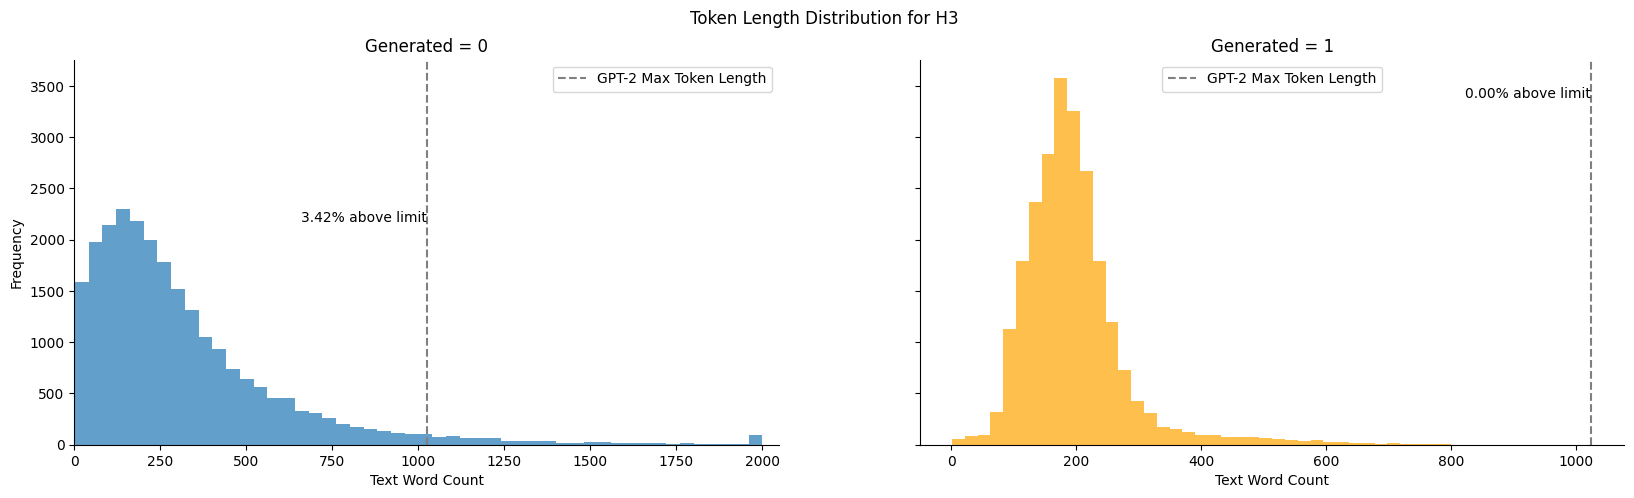

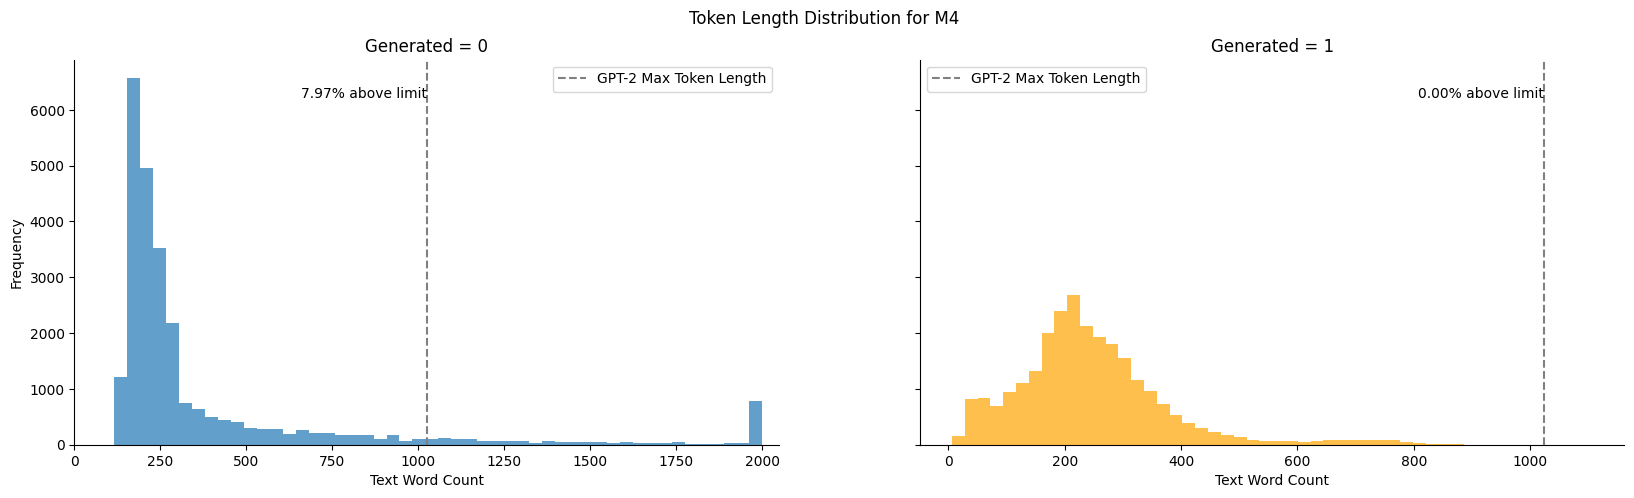

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


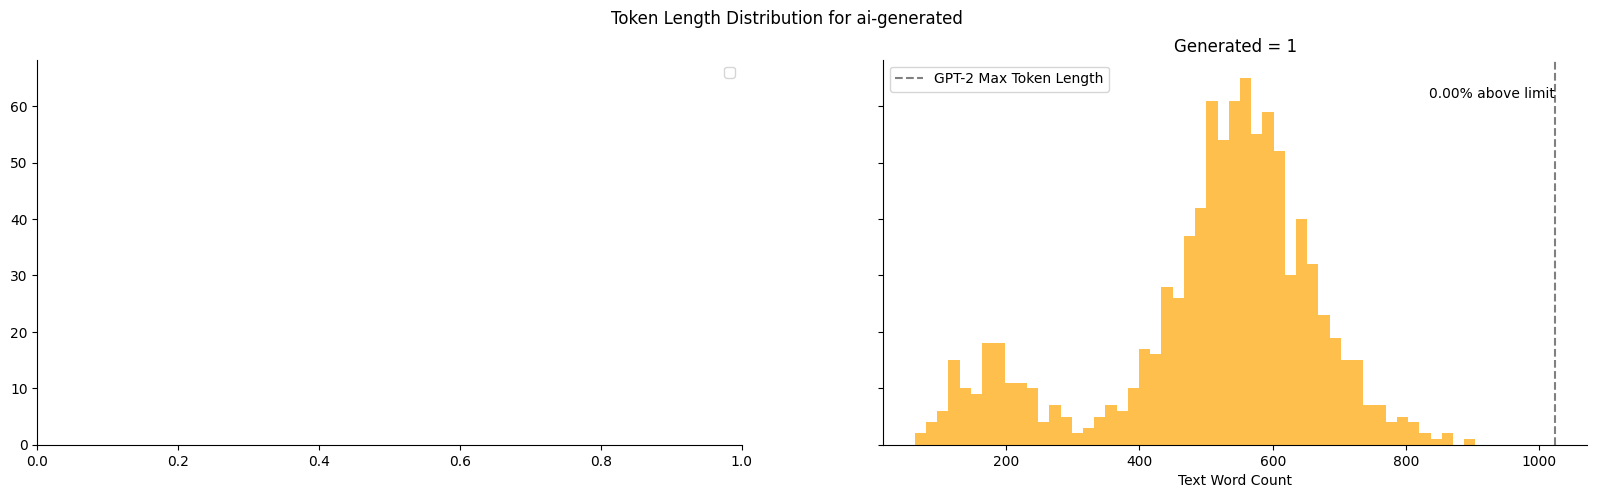

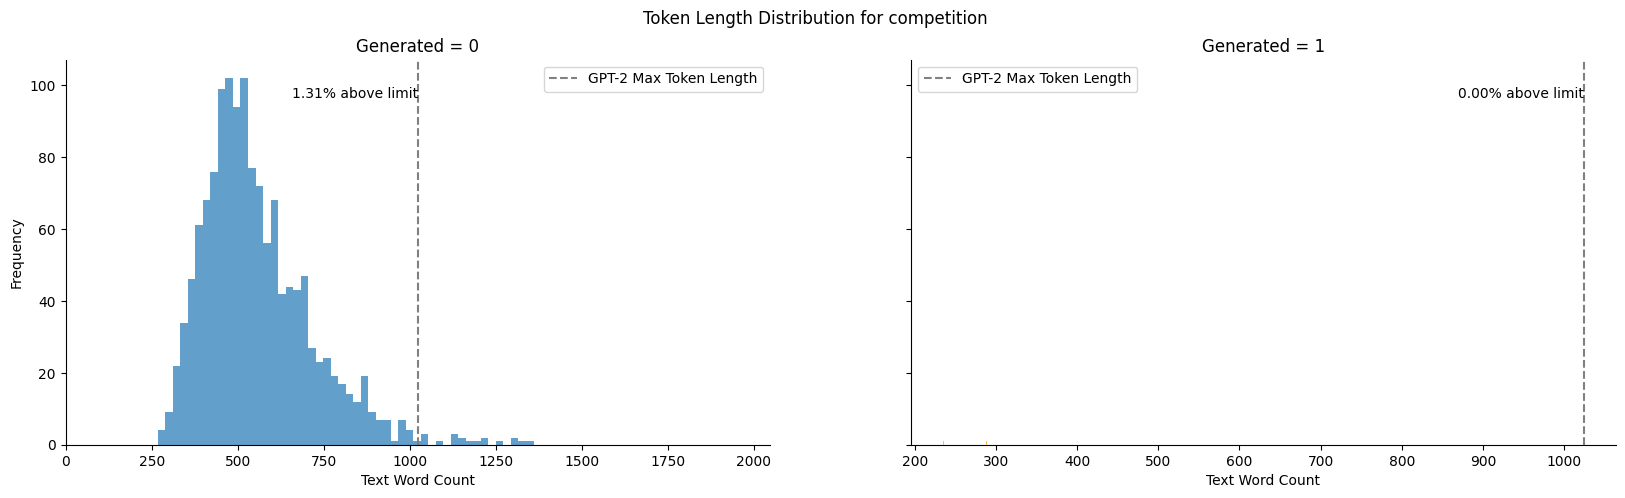

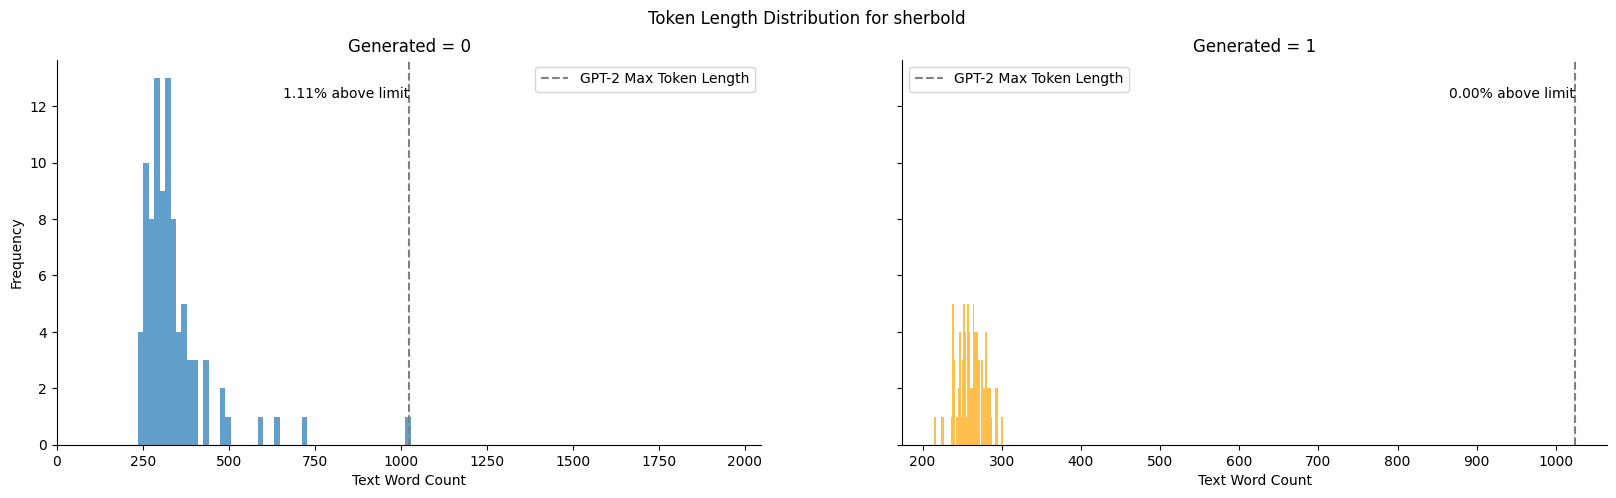

In [127]:
for dataset_name, group in training_data.groupby('dataset'):
    # Create two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
    fig.suptitle(f'Token Length Distribution for {dataset_name}')
    
    # First plot for generated = 0
    if dataset_name != 'ai-generated':
        axs[0].hist(group[group['generated'] == 0]['Text Word Count'], bins=50, alpha=0.7)
        axs[0].set_title('Generated = 0')
        axs[0].set_xlabel('Text Word Count')
        axs[0].set_ylabel('Frequency')
        axs[0].set_xlim(0, 2048)
        axs[0].axvline(x=1024, color='grey', linestyle='--', label='GPT-2 Max Token Length')
        percent_above_1024_gen0 = (group[(group['generated'] == 0) & (group['Text Word Count'] > 1024)]).shape[0] / group[group['generated'] == 0].shape[0]
        axs[0].text(1024, axs[0].get_ylim()[1] * 0.9, f'{percent_above_1024_gen0:.2%} above limit', horizontalalignment='right')
        
    # Second plot for generated = 1
    axs[1].hist(group[group['generated'] == 1]['Text Word Count'], bins=50, alpha=0.7, color='orange')
    axs[1].set_title('Generated = 1')
    axs[1].set_xlabel('Text Word Count')
    axs[1].axvline(x=1024, color='grey', linestyle='--', label='GPT-2 Max Token Length')
    percent_above_1024_gen1 = (group[(group['generated'] == 1) & (group['Text Word Count'] > 1024)]).shape[0] / group[group['generated'] == 1].shape[0]
    axs[1].text(1024, axs[1].get_ylim()[1] * 0.9, f'{percent_above_1024_gen1:.2%} above limit', horizontalalignment='right')
    
    # Common adjustments
    for ax in axs:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.legend()

    # Show the plot
    plt.show()

In [79]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [95]:
# create grid search with xgboost parameters and 5-fold cross validation with roc_auc as the scoring metric
xgb_grid = {
    'max_depth': [3, 4, 6],
    'learning_rate': [0.01, 0.03],
    'n_estimators': [50, 100, 200],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
}

xgb = XGBClassifier()
xgb_cv = GridSearchCV(xgb, xgb_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
xgb_cv.fit(training_data.drop(['id', 'text', 'dataset', 'source', 'prompt_id', 'generated'], axis=1), training_data['generated'])
cv_results = pd.DataFrame(xgb_cv.cv_results_)
cv_results.sort_values('rank_test_score', inplace=True)

xgb = xgb_cv.best_estimator_
xgb.fit(training_data.drop(['id', 'text', 'dataset', 'source', 'prompt_id', 'generated'], axis=1), training_data['generated'])

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categ

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [96]:
print(f'Best parameters: {xgb_cv.best_params_}')
print(f'Best score: {xgb_cv.best_score_}')

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best score: 0.5317427406901091


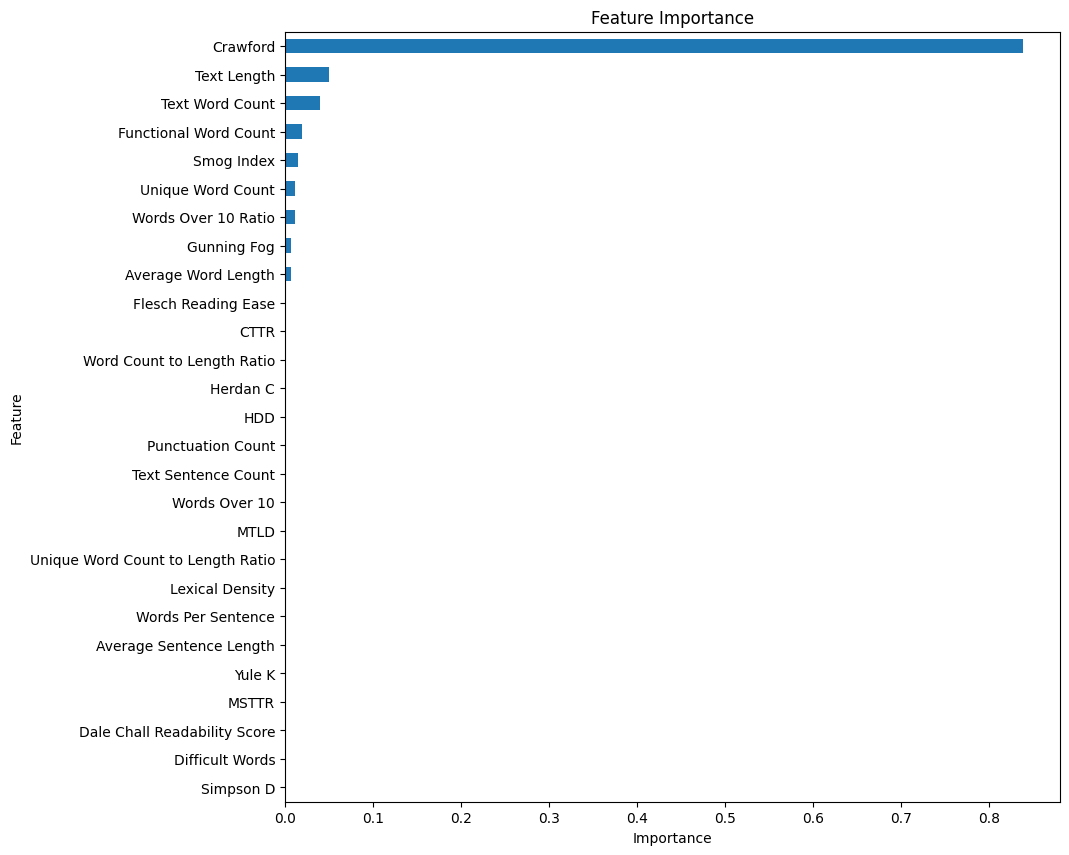

In [97]:
# plot feature importance ordered by importance
fig, ax = plt.subplots(figsize=(10, 10))
feature_importances = pd.Series(xgb.feature_importances_, index=training_data.drop(['id', 'text', 'dataset', 'source', 'prompt_id', 'generated'], axis=1).columns)
feature_importances.sort_values().plot.barh(ax=ax)
ax.set_title('Feature Importance')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
plt.show()


In [ ]:
corr = training_data.drop(['id', 'text', 'dataset', 'source', 'prompt_id'], axis=1).corr()
plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()


In [103]:
training_data.groupby('generated').agg(
    {'Text Word Count': ['mean', 'std'], 
     'MTLD': ['mean', 'std'],
     'Smog Index': ['mean', 'std'],
     'Flesch Reading Ease': ['mean', 'std'],
     'Crawford': ['mean', 'std']})

Text Word Count                  MTLD            Smog Index  \
                     mean        std       mean        std       mean   
generated                                                               
0              291.655273  90.766743  75.712049  25.068040  14.116000   
1              296.643763  94.810660  82.123860  25.749819  15.513002   

                    Flesch Reading Ease             Crawford            
                std                mean        std      mean       std  
generated                                                               
0          2.515687           46.503622  16.369098  3.630836  0.910121  
1          1.474729           37.355032   9.588898  4.150000  0.511978

In [ ]:
openai.api_key_path = Path('/Users/claygendron/Git/Files/OpenAI.txt')

In [ ]:
ai_role = """
    You are a student who is required to write an argumentative essay for a class assignment. 
    The essay should have a clear, concise, and defined thesis statement in the first paragraph. 
    Use logical transitions between the introduction, body, and conclusion. 
    Include body paragraphs that provide evidential support, considering different points of view and explaining how the evidence supports the thesis. 
    The conclusion should readdress the thesis in light of the evidence provided without introducing new information.
    
    You will be given a set of instructions and source text for the assignment.
    Be sure to address the questions being asked in the instructions and use information in the source text to build your essay.
"""

final_instructions = """
    Please write your essay.
    Write in paragraph format without the use of a title or headers.
"""

In [ ]:
def generate_ai_essay_response(
    ai_role=None, instructions=None, source_text=None, 
    final_instructions=None, length_distribution=None, 
    essay_start=None,
    model='gpt-3.5-turbo'
):
    """
    Generates an essay response from the OpenAI ChatGPT API.

    This function initializes a conversation with the OpenAI API using the provided arguments,
    which define the role of the AI, the instructions, the source text, and any final instructions
    for generating the essay. It then sends this conversation to the API and returns the generated
    essay response.

    Parameters
    ----------
    ai_role : str, optional
        The role description of the AI in the conversation, which instructs the AI on how to behave
        in the context of the essay (default is None, which should be set to a proper description).
    instructions : str, optional
        The initial set of instructions for the essay that the AI is to write (default is None).
    source_text : str, optional
        The source text information that the AI can use to form its response (default is None).
    final_instructions : str, optional
        Any final instructions to be considered by the AI when generating the essay (default is None).
    model : str, optional
        The identifier for the OpenAI language model to be used (default is 'gpt-3.5-turbo').

    Returns
    -------
    str
        The AI-generated essay response.
    """
    
    # Initialize the conversation with the AI
    if ai_role is None:
        formatted_ai_role = """
            Role:
            
            You are a student who is required to write an argumentative essay for a class assignment.
        """
    else:
        formatted_ai_role = f"""
            Role:
            
            {ai_role}
        """
        
    conversation = [
        {'role': 'system', 'content': ai_role}
    ]
    
    # Set instructions if provided
    if instructions is not None:
        formatted_instructions = f"""
            Instructions: 
            
            {instructions}
        """
        conversation.append({'role': 'user', 'content': formatted_instructions})
    
    # Set source text if provided
    if source_text is not None:
        formatted_source_text = f"""
            Source Text:
            
            {source_text}
        """
        conversation.append({'role': 'user', 'content': formatted_source_text})
    
    # Set final instructions if provided
    if final_instructions is not None:
        if length_distribution is not None:
            essay_length = sample_from_essay_len_distribution(length_distribution) - 100
        else:
            essay_length = 500
        
        formatted_final_instructions = f"""
            Final Instructions:
            
            {final_instructions}. The essay should be {essay_length} words long.
        """
        conversation.append({'role': 'user', 'content': formatted_final_instructions})
        
    # Set the essay start if provided
    if essay_start is not None:
        formatted_essay_start = f"""
            This is the start of the essay:
            
            {essay_start}
        """
        conversation.append({'role': 'user', 'content': essay_start})
    
    # Send the messages to the model
    response = openai.ChatCompletion.create(
        model=model,
        messages=conversation
    )
    
    # Assuming the last message is the AI's response to the source text
    return response['choices'][0]['message']['content']

In [ ]:
ai_role = """
    You are a student who is required to write an argumentative essay for a class assignment. 
    The essay should have a clear, concise, and defined thesis statement in the first paragraph. 
    Use logical transitions between the introduction, body, and conclusion. 
    Include body paragraphs that provide evidential support, considering different points of view and explaining how the evidence supports the thesis. 
    The conclusion should readdress the thesis in light of the evidence provided without introducing new information.
    
    You will be given a set of instructions and source text for the assignment.
    Be sure to address the questions being asked in the instructions and use information in the source text to build your essay.
"""

final_instructions = """
    Please write your essay.
    Write in paragraph format without the use of a title or headers.
"""

In [ ]:
instruct = train_prompts['instructions'][0]
source = train_prompts['source_text'][0]

text = generate_ai_essay_response(ai_role, instruct, source, final_instructions)

In [ ]:
# write text to file
with open('ai_essay_2.txt', 'w') as f:
    f.write(text)

In [ ]:
text_tokens = tokenize_text(text)
text_tokens_len = len(text_tokens[0])
print(f'Text token length: {text_tokens_len}')

In [ ]:
def get_ai_response(instruction, source_text):
    messages = [
        {'role': 'system', 'content': 'You are a gifted poet.'},
        {'role': 'user', 'content': f'{instruction}: {source_text}'}
    ]
    response = openai.ChatCompletion.create(
        model='gpt-3.5-turbo',  # This should be the model you want to use
        messages=messages,
        max_tokens=150  # Adjust the number of tokens as needed
    )
    return response['choices'][0]['message']['content'].strip()

In [ ]:
instruction = 'Write a poem using:'
source_text = 'I Thought I Hated Pop Music. "Dancing Queen" Changed My Mind.'

get_ai_response(instruction, source_text)